<a href="https://colab.research.google.com/github/shadab4150/Global_wheat_detection/blob/master/Global_wheat_detection_%7C_A_new_perspective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# Example

# !kaggle competitions download -c "jigsaw-unintended-bias-in-toxicity-classification"

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!echo '{"username": "ianmoone0617", "key": "47d1ab33bfcd8eb9ebefb3deadf2f80e"}' > /root/.kaggle/kaggle.json


In [ ]:
import kaggle
kaggle.api.authenticate()
kaggle.api.competition_download_files("global-wheat-detection", path='/content/', quiet=False)

  1%|          | 7.00M/607M [00:00<00:09, 69.3MB/s]

100%|██████████| 607M/607M [00:03<00:00, 202MB/s]

In [ ]:
!unzip '/content/global-wheat-detection.zip' -d '/content/wheat'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp '/content/global-wheat-detection.zip' '/content/drive/My Drive/Dataset'

In [ ]:
!pip install object-detection-fastai

  Created wheel for object-detection-fastai: filename=object_detection_fastai-0.0.6-cp36-none-any.whl size=31580 sha256=45f392bae9546a4ec39a458bbd1b46a4506da7d03812fdfde199c39a90ebf567
  Stored in directory: /root/.cache/pip/wheels/4c/79/9c/7299e94e248a7102202b922f02da86502f2e6e35dbe07706c8
Successfully built object-detection-fastai


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict
import os
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as immg
from sklearn.model_selection import StratifiedKFold,KFold

from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
path = Path('/content/wheat');path.ls()

[PosixPath('/content/wheat/train'),
 PosixPath('/content/wheat/train.csv'),
 PosixPath('/content/wheat/test'),
 PosixPath('/content/wheat/sample_submission.csv')]

In [ ]:
sns.set_style('darkgrid')

In [ ]:
train = pd.read_csv(path/'train.csv')

In [ ]:
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [ ]:
tr = train.image_id.value_counts()
tr = pd.DataFrame({'image_id':tr.index,'wheat_count':tr.values})
tr = tr.sample(frac=1.,random_state=2020)

In [ ]:
fnames = get_files(path/'train')

In [ ]:
def get_lbl_img(train):
    wheat2bbox = {}
    train['label'] = 'wheat'
    grp = train.image_id.unique()
    tr_gr = train.groupby(['image_id'])
    from tqdm.notebook import tqdm
    for i in tqdm(range(len(grp))):
        name = str(grp[i]) + '.jpg'
        bbox = []
        temp_b = []
        temp = tr_gr.get_group(grp[i])
        tt = temp.loc[:,'bbox'].values
        for j in range(len(temp)):
            t = tt[j][1:-1].split(',')
            t = [float(x) for x in t]
            t[2],t[3] = t[0]+t[2],t[1]+t[3]
            t1 = [t[1],t[0],t[3],t[2]]   # inverse in fromat w,h
            temp_b.append(t1)
        bbox.append(temp_b)
        bbox.append(['wheat']*len(temp))
        wheat2bbox[name] = bbox
    return wheat2bbox

In [ ]:
wheat2bbox = get_lbl_img(train)

In [ ]:
get_y_func = lambda o:wheat2bbox[Path(o).name]

In [ ]:
data = (ObjectItemList.from_df(tr,path, folder = 'train' , suffix = '.jpg',cols='image_id')
        #Where are the images? 
        .split_by_rand_pct(0.1)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(size = 512, tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=4, collate_fn=bb_pad_collate))   

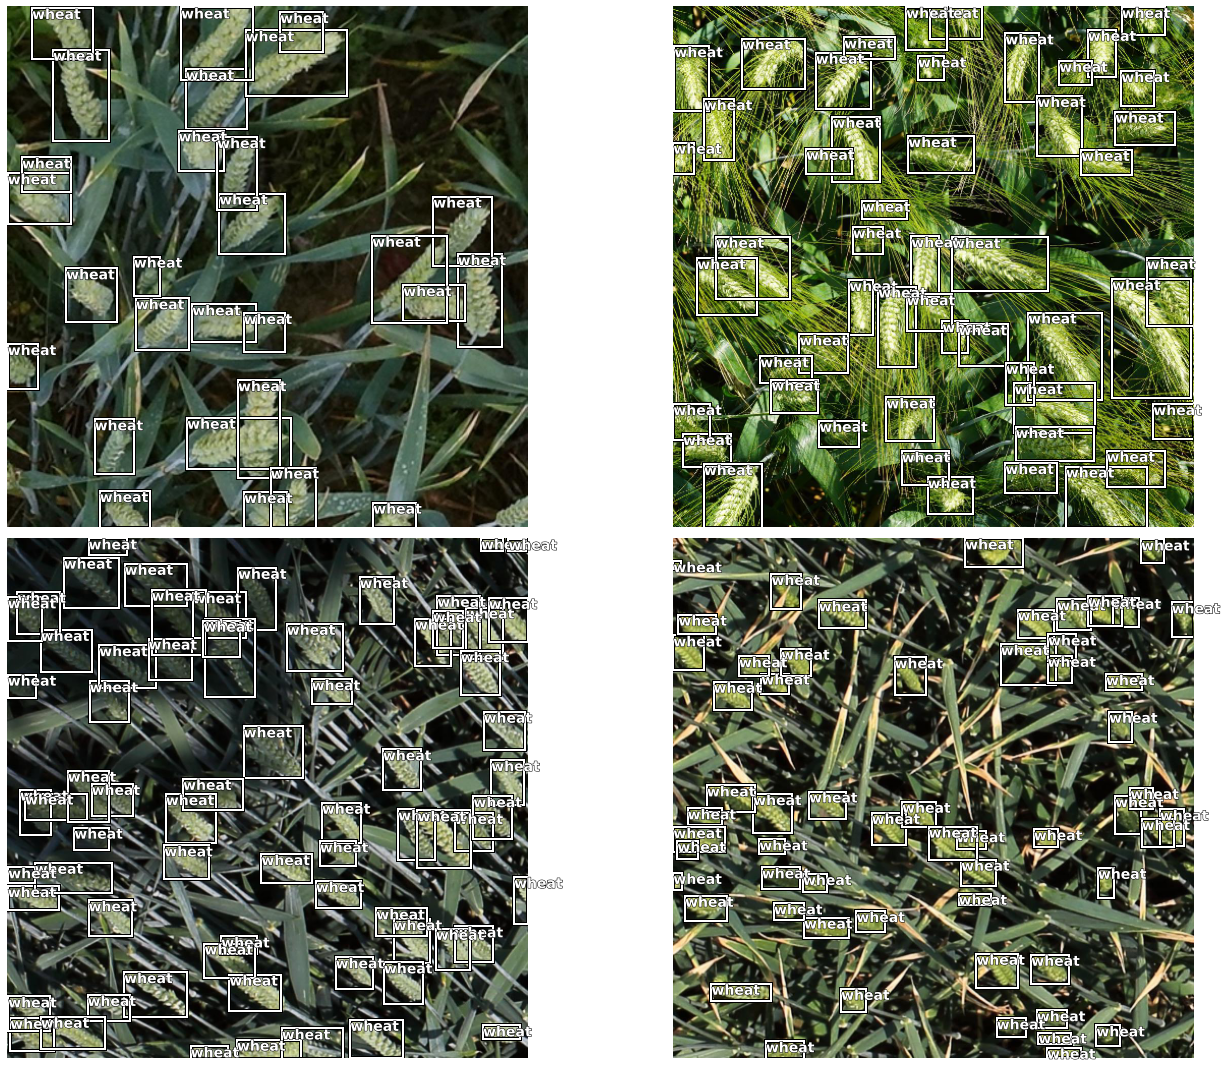

In [ ]:
data.show_batch(2 , figsize = (20,15) )

### What Is an Anchor Box?
* **Anchor boxes are a set of predefined bounding boxes of a certain height and width. These boxes are defined to capture the scale and aspect ratio of specific object classes you want to detect** and are typically chosen based on object sizes in your training datasets. During detection, the predefined anchor boxes are tiled across the image. The network predicts the probability and other attributes, such as background, intersection over union (IoU) and offsets for every tiled anchor box. The predictions are used to refine each individual anchor box. You can define several anchor boxes, each for a different object size. Anchor boxes are fixed initial boundary box guesses.

* **The network does not directly predict bounding boxes, but rather predicts the probabilities and refinements that correspond to the tiled anchor boxes.** The network returns a unique set of predictions for every anchor box defined. The final feature map represents object detections for each class. The use of anchor boxes enables a network to detect multiple objects, objects of different scales, and overlapping objects.

### Advantage of Using Anchor Boxes
* When using anchor boxes, you can evaluate all object predictions at once. Anchor boxes eliminate the need to scan an image with a sliding window that computes a separate prediction at every potential position. 

In [ ]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.45, 0.55, 0.75, 0.95, 1.05, 1.15])

In [ ]:
size = 512

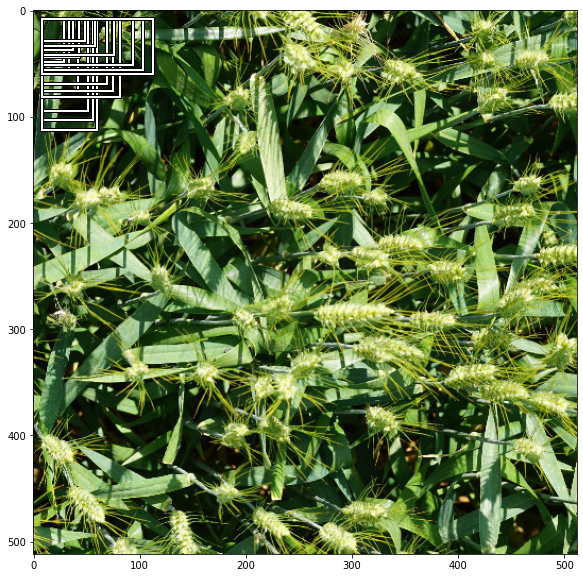

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [ ]:
len(anchors)

24480

In [ ]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet50, True, -2)

model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias = -4., n_conv = 2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit,
                callback_fns=[ShowGraph,BBMetrics],
                metrics=[voc],model_dir = '/content/')

In [ ]:
learn.split([model.encoder[6], model.c5top5]);
#learn.freeze_to(-2)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


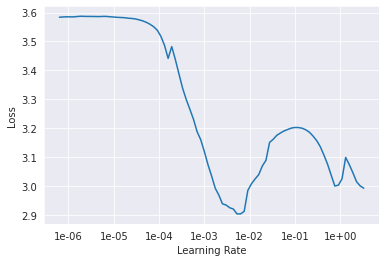

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
gc.collect()

1042

GT: 100%|██████████| 15265/15265 [00:05<00:00, 2725.01it/s]


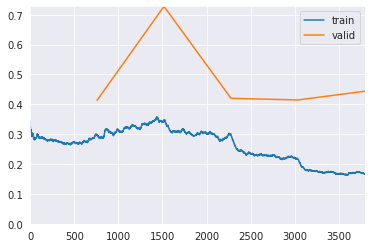

GT: 100%|██████████| 15265/15265 [00:06<00:00, 2538.02it/s]


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

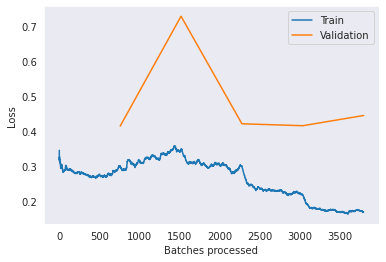

In [ ]:
learn.recorder.plot_losses()

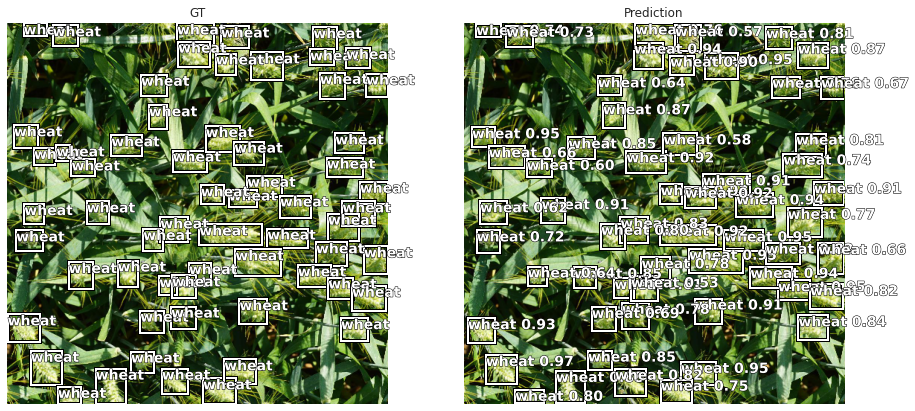

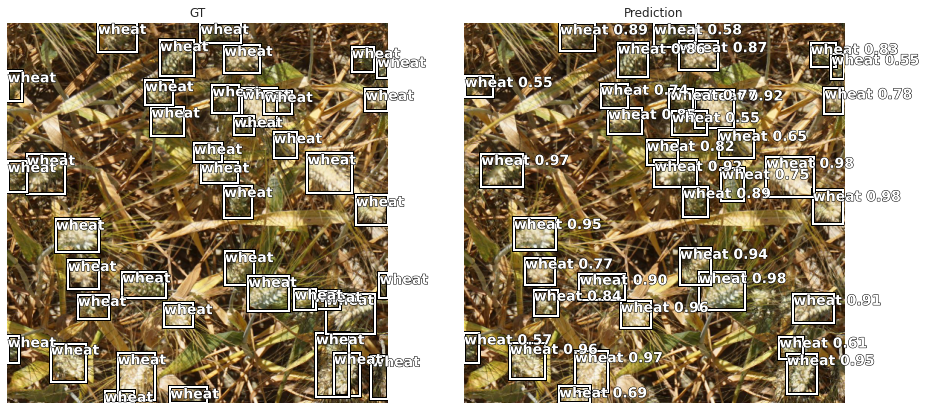

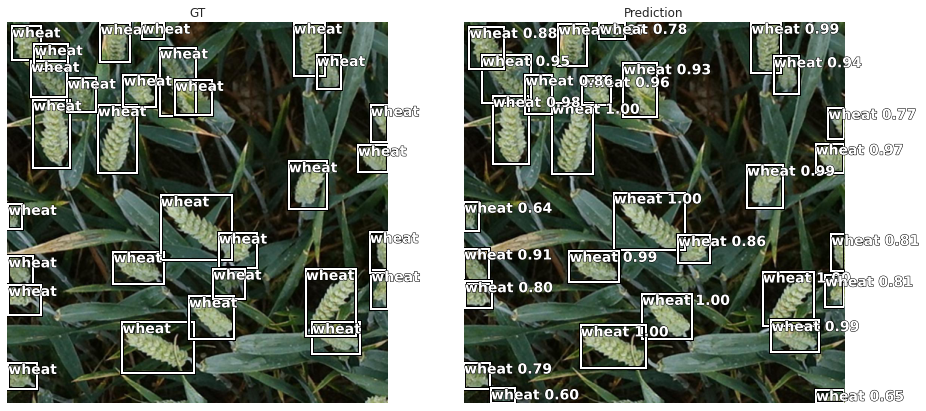

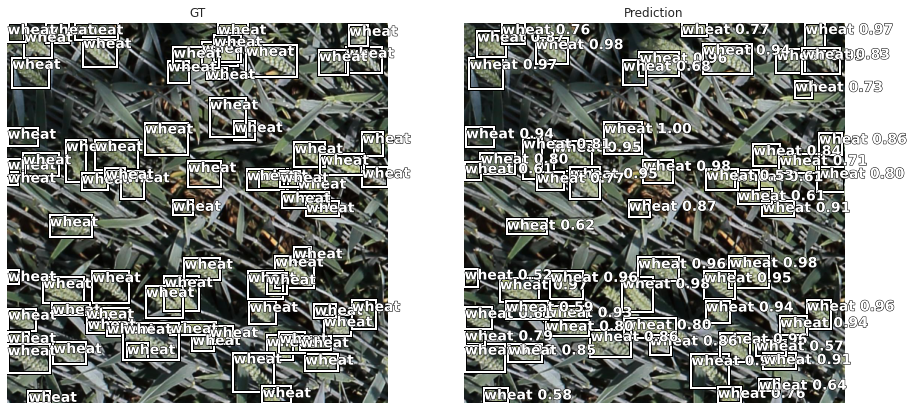

In [ ]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=4)